In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
images_root = 'Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)

In [ ]:
def collate_fn(examples):
    imgs, targets = zip(*examples)
    pixel_values = torch.stack(imgs)
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [ ]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [ ]:
mode = 'arousal'
seed = 0

In [ ]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)
from torch.utils.data import random_split


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor()])

train_dataset = AffectNetDataset('Affectnet/training.csv',
                                 images_root,
                                 mode,
                                 crop=False,
                                 transform=transform,
                                 invalid_files=train_invalid_files)

val_dataset = AffectNetDataset('Affectnet/validation.csv',
                               images_root,
                               mode,
                               crop=False,
                               transform=transform,
                               invalid_files=val_invalid_files)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))


train: 320739
validation: 4500


訓練データの分布をカーネル密度推定により平滑化し，MSEに重みづけする

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from scipy.stats import gaussian_kde

class KDEWeightLoss(_Loss):
    def __init__(self, dataset, mode, bw_method=None, eps=1e-6, device=None):
        super(KDEWeightLoss, self).__init__()
        assert mode in ('valence', 'arousal', 'valence-arousal')
        self.mode = mode
        self.bw_method = bw_method
        self.eps = eps
        self.device = device
        self.kernel = self._calc_kernel(dataset.df)
    
    def forward(self, pred, target):
        loss = torch.mean(torch.dot(torch.tensor(1 / (self.kernel(target.cpu().T) + self.eps)).float().to(self.device),
                                    ((pred - target) ** 2).sum(1)))
        return loss
    
    def _calc_kernel(self, df):
        if self.mode == 'arousal':
            data = df[self.mode].to_numpy().T
        elif self.mode == 'valence':
            data = df[self.mode].to_numpy().T
        else:
            data = df[['valence', 'arousal']].to_numpy().T
        return gaussian_kde(data, bw_method=self.bw_method)

In [ ]:
from transformers import Trainer
import wandb

class KDEWeightLossTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = KDEWeightLoss(dataset=train_dataset,
                                      mode=mode,
                                      bw_method=0.2,
                                      device=self.args.device).to(self.args.device)
        self.mse = nn.MSELoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.loss_fct(logits, labels)
        mse = self.mse(logits, labels)
        rmse = torch.sqrt(mse)
        wandb.log({'train/mse': mse, 'train/rmse': rmse})
        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=1,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', name='KDE-aro', id='kde_aro_230403')

args = TrainingArguments(
    f"affectnet-kde-aro",
    evaluation_strategy="steps",
    eval_steps=1000,
    save_strategy='steps',
    save_steps=1000,
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=1e-3,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to='wandb'
)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_metrics(eval_pred):
    preds, targets = eval_pred
    mse = mean_squared_error(targets, preds, squared=True) / 2
    rmse = np.sqrt(mse)
    return {'mse': mse, 'rmse': rmse}

In [ ]:
from transformers import EarlyStoppingCallback

trainer = KDEWeightLossTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.05)]
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_state()
trainer.save_model()
wandb.finish()

In [ ]:
from tqdm import tqdm

def CLE_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(feature, output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.stack(labels)

In [ ]:
from umap import UMAP
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

def plot_tokens(tokens, targets, n_neighbors):
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    umap = UMAP(n_neighbors=n_neighbors)
    xy = np.array(umap.fit_transform(tokens.numpy()))
    x = xy[:, 0]
    y = xy[:, 1]
    z = targets
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_title('valence')
    mp = ax.scatter(x, y,
                    alpha=1,
                    c=z,
                    cmap='Oranges',
                    vmin=-1,
                    vmax=1,
                    s=3)
    fig.colorbar(mp, ax=ax)
    plt.show()
    return fig


In [ ]:
tokens, targets = CLE_tokens(model,
                             feature_extractor,
                             val_dataset,
                             device)
print(tokens.shape, targets.shape)

100%|██████████| 4500/4500 [00:49<00:00, 90.88it/s] 

torch.Size([4500, 768]) torch.Size([4500, 1])


In [ ]:
finetuned_fig = plot_tokens(tokens, targets, 10)

In [ ]:
wandb.init(project='AffectNet-vit', id='kde_aro_230403', resume='must')
finetuned_fig = plot_tokens(tokens, targets, 10)
wandb.log({'finetuned-plot': wandb.Image(finetuned_fig)})

In [ ]:
non_finetuned_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                                num_labels=1,
                                                                problem_type='regression')

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 4500/4500 [02:47<00:00, 26.90it/s]


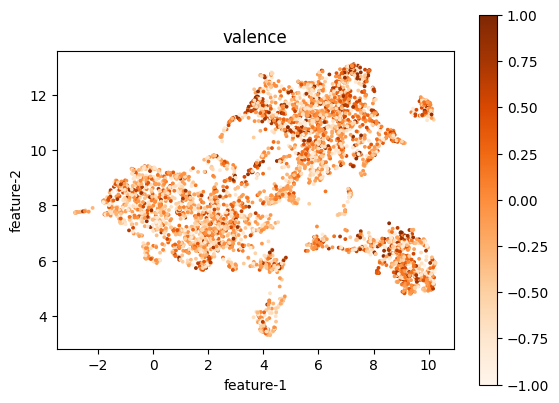

In [ ]:
tokens, targets = CLE_tokens(non_finetuned_model.to(device),
                             feature_extractor,
                             val_dataset,
                             device)
non_finetuned_plot = plot_tokens(tokens, targets, 10)
wandb.log({'non-finetuned-plot': wandb.Image(non_finetuned_plot)})

In [ ]:
wandb.finish()